In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
# Constants

X_MIN, X_MAX, Y_MIN, Y_MAX = 0, 10, 0, 10
obs_dim = 10
state_dim = 2
T = np.random.randn(obs_dim, state_dim)

# Centroids
centroids = []
for x in (X_MAX//4, X_MAX * 3//4):
    for y in (Y_MAX//4, Y_MAX * 3//4):
        centroids.append(np.array((x, y)))

rooms = []
for x in (X_MAX//2, X_MAX):
    for y in (Y_MAX//2, Y_MAX):
        rooms.append((x-X_MAX//2, y-Y_MAX//2, x, y))
def initiation_set(room_limits):
    def _init(state):
        low_limit = room_limits[0:2]
        high_limit = room_limits[2:]
        return (state[0] > low_limit[0] and state[0] < high_limit[0] and state[1] > low_limit[1] and state[1] < high_limit[1])
    return _init


def effect_sample(centroid_1, centroid_2):
    def _effect(state):
        c = np.random.randint(0, 2)
        centroids = [centroid_1, centroid_2]
        return np.random.multivariate_normal(mean=np.zeros(state_dim), cov=np.eye(state_dim)/2**6, size=1) + centroids[c]
    return _effect


# fix room order to be clockwise
for l in (rooms, centroids):
    _r = l[2]
    l[2] = l[3]
    l[3] = _r

# Synthetic option definition
effect_dists_params = []
initiation_sets = []
std_dev = 1
for i, room in enumerate(rooms):
    initiation_sets.append(initiation_set(room))
    effect_dists_params.append(effect_sample(centroids[(i-1)%4], centroids[(i+1)%4]))

In [3]:
# Data Generation

N = 5000

x = np.random.uniform(0, X_MAX, N)
y = np.random.uniform(0, Y_MAX, N)

s = np.array((x,y)).T

masks = []
for i, init_set in enumerate(initiation_sets):
    mask = np.zeros((N,1))
    for j in range(N):
        mask[j] = float(init_set(s[j]))
    masks.append(mask)

masks = np.array(masks)
I_s = np.array(masks).transpose((1,0,2))[...,0] # initiation vector at s

# generate next states
s_prime = []
for i, effect_dist in enumerate(effect_dists_params):
    _s_prime = []
    for j in range(N):
        _s_prime.append(effect_dist(s[j]))
    s_prime.append(np.array(_s_prime).squeeze())


# s_prime = np.array(s_prime) * masks  + s[np.newaxis] * (1-masks)
s_prime = np.array(s_prime)

masks = masks.reshape((-1,))

I_s_prime = []
for action in range(len(initiation_sets)):
    _m = np.zeros((N,len(initiation_sets)))
    for i, init_set in enumerate(initiation_sets):
        for j in range(N):
            _m[j, i] = float(init_set(s_prime[action][j]))
    I_s_prime.append(_m)

# Random affine transformation
x = np.einsum('ij, kj->ki', T, s)
x_prime = np.einsum('ij, lkj->lki', T, s_prime)

data = []
for i in range(len(effect_dists_params)):
    data.append((x, x_prime[i], I_s, I_s_prime[i], s, s_prime[i]))

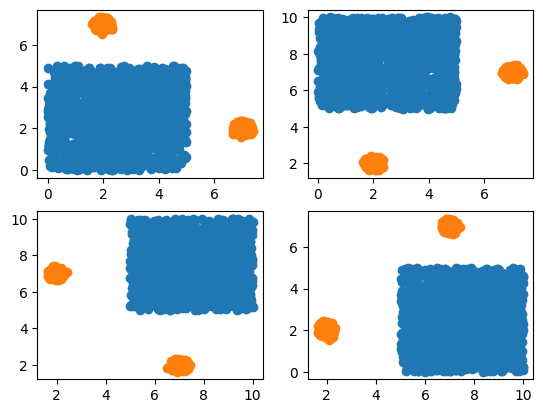

In [4]:
#Plot to Check
for r in range(4):
    plt.subplot(2, 2, r+1) 
    plt.scatter(s[I_s[:, r]==1, 0], s[I_s[:, r]==1, 1])
    plt.scatter(s_prime[r, I_s[:, r]==1,0], s_prime[r, I_s[:, r]==1,1])
plt.show()

In [5]:
# Models
from inspect import trace


n_actions = 4
hidden_size = 128
latent_dim = 2

def init_models():
    encoder = nn.Sequential(
                                nn.Linear(obs_dim, hidden_size),
                                nn.ReLU(),
                                nn.Linear(hidden_size, latent_dim + 1)
                        )

    linear_1 = nn.Sequential(nn.Linear(latent_dim + n_actions, hidden_size),
                             nn.Tanh())
    linear_2 = nn.Sequential(nn.Linear(latent_dim + n_actions, hidden_size),
                             nn.Sigmoid())

   


    transition_model = nn.Sequential(
                                    # nn.Linear(latent_dim + n_actions, hidden_size),
                                    # nn.ReLU(),
                                    # nn.Linear(hidden_size, hidden_size),
                                    # nn.ReLU(),
                                    # nn.Linear(hidden_size, hidden_size),
                                    # nn.ReLU(),
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, latent_dim + 1)
                                )

    grounding_model = nn.Sequential(
                                    nn.Linear(latent_dim, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, obs_dim + 1)
                                )
    
    initiation_classifier = nn.Sequential(
                                    nn.Linear(latent_dim, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, n_actions),
                                    nn.Sigmoid()
                                )
    return encoder, transition_model, grounding_model, initiation_classifier, linear_1, linear_2

encoder, transition_model, grounding_model, initiation_classifier, linear_1, linear_2 = init_models()

In [6]:
### Training hyperparameters
n_epochs = 60
minibatch_size = 32
n_samples = 30  # samples to approximate expectation
learning_rate = 1e-4
beta = 0.01  # hyperparameter to control information bottleneck


In [7]:
# Cast data to float torch tensor and add action one-hot encoding
in_data = []
out_data = []
initiations_s = []
initiations_s_prime = []
for i in range(n_actions):
    data[i] = [torch.from_numpy(_tensor).float() for _tensor in data[i]]
    actions = nn.functional.one_hot(torch.ones(data[i][0].size(0)).long() * i, n_actions)
    data[i] = (torch.cat((data[i][0], actions), dim=1), data[i][1], data[i][2], data[i][3], data[i][4], data[i][5]) 
    in_data.append(data[i][0])
    out_data.append(data[i][1])
    initiations_s.append(data[i][2])
    initiations_s_prime.append(data[i][3])

In [8]:
in_data = torch.cat(in_data, dim=0)[masks == 1]
out_data = torch.cat(out_data, dim=0)[masks == 1]
initiations_s = torch.cat(initiations_s, dim=0)[masks==1]
initiations_s_prime = torch.cat(initiations_s_prime, dim=0)[masks==1]

In [9]:
# Prepare data

rand_order = torch.randperm(in_data.size(0))
in_data = torch.index_select(in_data, 0, rand_order)
out_data = torch.index_select(out_data, 0, rand_order)
initiations_s = torch.index_select(initiations_s, 0, rand_order)
initiations_s_prime = torch.index_select(initiations_s_prime, 0, rand_order)


def minibatches(data_list, batch_size):
    N = in_data.size(0)
    n_batches = N//batch_size + int(N%batch_size != 0)
    for i in range(n_batches):
        minibatch = [d[i*batch_size:(i+1)*batch_size] for d in data_list]
        # yield (in_data[i*batch_size:(i+1)*batch_size], out_data[i*batch_size:(i+1)*batch_size], initiations[i*batch_size:(i+1)*batch_size])
        yield minibatch

models = (encoder, transition_model, grounding_model, initiation_classifier)
models_params = []
for model in models:
    for param in model.parameters():
        models_params.append(param)
optimizer_forward = torch.optim.RMSprop(models_params, lr=learning_rate)

In [10]:
classifier_loss = nn.BCELoss()
epsilon=1
def loss(target, predicted_s_prime, predicted_z):
    
    target = target.unsqueeze(1).unsqueeze(1)
    encoding_loss = 0.5 * predicted_z[..., 0:latent_dim].pow(2).sum(dim=-1) + latent_dim * (torch.exp(predicted_z[..., -1]) - predicted_z[..., -1])
    prediction_loss = -0.5 * (target - predicted_s_prime[..., 0:obs_dim]).pow(2).sum(dim=-1, keepdim=True)/(torch.exp(2*predicted_s_prime[..., obs_dim:]) + epsilon) - obs_dim * predicted_s_prime[..., obs_dim:]
    _loss = -((1-beta)*prediction_loss - beta * encoding_loss)
    return _loss

def consistency_loss(target, encoded_z_prime, n_samples=10):

    noise = torch.normal(0, 1, (target.size(0), n_samples, latent_dim))
    z_prime_samples = torch.exp(encoded_z_prime.unsqueeze(1)[:, :, -2:-1]) * noise + encoded_z_prime.unsqueeze(1)[:,:, :-1]  
    s_prime_params = grounding_model(z_prime_samples)
    _means = s_prime_params[..., :obs_dim]
    _vars = torch.exp(2*s_prime_params[..., obs_dim:])
    _target_prediction_sim = torch.einsum('...bj,...bk->...b' ,target.unsqueeze(-2), _means)
    _mean_norm = torch.einsum('...j,...k->...' , _means, _means)
    _target_norm = torch.einsum('...bj,...bk->...b', target, target).unsqueeze(1)
    _losses = obs_dim * torch.log(_vars.squeeze()) + (2 * _target_prediction_sim + _mean_norm + _target_norm)/_vars.squeeze() 
    return _losses

def contrained_transition(transition_params, encoded_z_prime): # mean-seeking
    epsilon=1e-5
    mean_t = transition_params[..., :latent_dim]
    log_sigma_t = transition_params[..., latent_dim:]
    mean_z = encoded_z_prime[..., :latent_dim].unsqueeze(1)
    log_sigma_z = encoded_z_prime[..., latent_dim:].unsqueeze(1)
    entropy = latent_dim * 2 * log_sigma_t

    _loss = 0.5 * (2 * latent_dim * log_sigma_t  + ((mean_z.pow(2) + torch.exp(2*log_sigma_z))/(torch.exp(2*log_sigma_t) + epsilon)).sum(dim=-1, keepdim=True) - 2*torch.einsum('...i, ...j->...', mean_t, mean_z).unsqueeze(-1)/(torch.exp(2*log_sigma_t)+epsilon) + torch.einsum('...i, ...j->...', mean_t, mean_t).unsqueeze(-1)/(torch.exp(2*log_sigma_t)+epsilon))
    return (_loss - entropy).mean(-2)

def transition_consistency(transition_params, encoded_z_prime): # mode-seeking
    epsilon=1e-5
    mean_t = transition_params[..., :latent_dim]
    log_sigma_t = transition_params[..., latent_dim:]
    mean_z = encoded_z_prime[..., :latent_dim].unsqueeze(1)
    log_sigma_z = encoded_z_prime[..., latent_dim:].unsqueeze(1)
    entropy = latent_dim * 2 * log_sigma_t

    _loss = 0.5 * (2 * latent_dim * log_sigma_z  + ((mean_t.pow(2) + torch.exp(2*log_sigma_t))/(torch.exp(2*log_sigma_z) + epsilon)).sum(dim=-1, keepdim=True) - 2*torch.einsum('...i, ...j->...', mean_t, mean_z).unsqueeze(-1)/(torch.exp(2*log_sigma_z)+epsilon) + torch.einsum('...i, ...j->...', mean_z, mean_z).unsqueeze(-1)/(torch.exp(2*log_sigma_z)+epsilon))
    return (_loss - entropy).mean(-2)


def forward_loss(inp, target, predicted_s_prime, predicted_z, predicted_z_prime, s_prime_params):
    return loss(target, predicted_s_prime, predicted_z)

def training_loop(in_data, out_data, initiations_s, initiations_s_prime, n_epochs, optimizer, loss_fn=forward_loss, print_loss=False):

    for i in range(n_epochs):
        for _in, _out, _init_s, _init_s_prime in minibatches((in_data, out_data, initiations_s, initiations_s_prime), minibatch_size):
            ## Forward pass
            actions = _in[..., obs_dim:].unsqueeze(1).repeat_interleave(n_samples, dim=1)
            z = encoder(_in[...,:obs_dim])  # encode
            # Predict next abstract state
            noise = torch.normal(0, 1, (_in.size(0), n_samples, latent_dim))
            z_ = torch.exp(z.unsqueeze(1)[:, :, -2:-1]) * noise + z.unsqueeze(1)[:,:, :-1]   
            z_a = torch.cat((z_, actions), dim=-1)

            
            z_prime = transition_model(linear_1(z_a) * linear_2(z_a))
            
            epsilon = torch.normal(0, 1, (_in.size(0), n_samples, latent_dim))
            z_prime_samples = torch.exp(z_prime[:, :, -2:-1]) * epsilon + z_prime[:,:, :-1]  
            
            encoded_z_prime = encoder(_out)
            # z_prime_samples = torch.exp(encoded_z_prime.unsqueeze(1)[:, :, -2:-1]) * epsilon + encoded_z_prime.unsqueeze(1)[:,:, :-1] 

            # predict next ground state
            s_prime = grounding_model(z_prime_samples).unsqueeze(2)
            # s_prime = grounding_model(encoded_z_prime)
            epsilon = torch.normal(0, 1, (_in.size(0), n_samples, n_samples, obs_dim))
            s_prime_samples = torch.exp(s_prime[..., :obs_dim]) * epsilon + s_prime[..., :obs_dim]
            # s_prime = s_prime.squeeze(1)
            
            # Predict initiation vector from (z, z')
            predicted_I_s = initiation_classifier(z_[:, 0])
            predicted_I_s_prime = initiation_classifier(z_prime_samples[:, 0])

            # initiation_prediction = predicted_I_s.squeeze()#torch.cat((predicted_I_s, predicted_I_s_prime), dim=0).squeeze()
            # initiation_target = _init_s#torch.cat((_init_s, _init_s_prime), dim=0)
            initiation_prediction = torch.cat((predicted_I_s, predicted_I_s_prime), dim=0).squeeze()
            initiation_target = torch.cat((_init_s, _init_s_prime), dim=0)
            
            
            # binary classifier loss
            _classifier_loss = classifier_loss(initiation_prediction, initiation_target)
            
            _target = _out
            # _transition_constraint = contrained_transition(z_prime.detach(), encoded_z_prime).mean()
            _transition_constraint = transition_consistency(z_prime, encoded_z_prime.detach()).mean()
            _consistency_loss = consistency_loss(_out, encoded_z_prime).mean()
            _encoding_loss = loss_fn(_in, _target, s_prime, z, z_prime_samples, s_prime).mean()

            trans_const = 0.2

            _loss = (1-trans_const) * nn.functional.gelu(10 *_encoding_loss) + nn.functional.relu(0 * _consistency_loss) + 100 * _classifier_loss + trans_const * nn.functional.leaky_relu(1 * _transition_constraint, negative_slope=0.001)
            # _loss = _encoding_loss + _consistency_loss + _transition_constraint

            
            if print_loss:
                print(f"{i}: Encoding Loss {_encoding_loss}, Transition Loss {_transition_constraint}, Classifier Loss {_classifier_loss}, Total Loss {_loss}")
            
            ### zero grads 
            optimizer.zero_grad()
            ### backward pass
            _loss.backward()
            
            ### update
            optimizer.step()

In [11]:
# Train Forward Loss
training_loop(in_data, out_data, initiations_s, initiations_s_prime,  n_epochs, optimizer_forward, print_loss=True)

0: Encoding Loss 197.0939178466797, Transition Loss 18373.435546875, Classifier Loss 0.6976369619369507, Total Loss 5321.2021484375
0: Encoding Loss 207.88912963867188, Transition Loss 22103.064453125, Classifier Loss 0.6762166023254395, Total Loss 6151.34765625
0: Encoding Loss 227.24862670898438, Transition Loss 24599.46484375, Classifier Loss 0.6608837246894836, Total Loss 6803.970703125
0: Encoding Loss 179.86814880371094, Transition Loss 15748.9052734375, Classifier Loss 0.6476562023162842, Total Loss 4653.49169921875
0: Encoding Loss 190.16867065429688, Transition Loss 19384.158203125, Classifier Loss 0.6300100088119507, Total Loss 5461.18212890625
0: Encoding Loss 175.08116149902344, Transition Loss 9169.4140625, Classifier Loss 0.6315562129020691, Total Loss 3297.687744140625
0: Encoding Loss 173.58213806152344, Transition Loss 14154.3955078125, Classifier Loss 0.6212636232376099, Total Loss 4281.66259765625
0: Encoding Loss 210.2854461669922, Transition Loss 16513.43359375, Cl

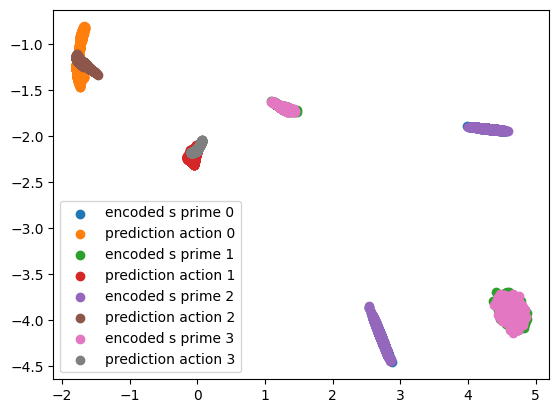

In [12]:
# Evaluate
def plot_z_space(data):
    with torch.no_grad():
        for i in range(n_actions):
            i_s = data[i][2]
            s = data[i][0][...,:obs_dim]
            a = data[i][0][...,obs_dim:]
            s_prime = data[i][1][..., :obs_dim]
            z = encoder(s[i_s[...,i]==1])
            z_prime_encoded = encoder(s_prime)
            z_a = torch.cat((z[:, 0:-1], a[i_s[...,i]==1]), dim=-1)

            z_prime = transition_model(linear_1(z_a) * linear_2(z_a))
            s_prime = grounding_model(z[:, 0:-1])
            # plt.scatter(z[:, 0], z[:, 1], label=f"encoded action {i}")
            
            plt.scatter(z_prime_encoded[:, 0], z_prime_encoded[:, 1], label=f"encoded s prime {i}")
            plt.scatter(z_prime[:, 0], z_prime[:, 1], label=f"prediction action {i}")
            # plt.scatter(s_prime[:, 0], s_prime[:, 1], label=f"action {i}")
        plt.legend()
        plt.show()

plot_z_space(data)

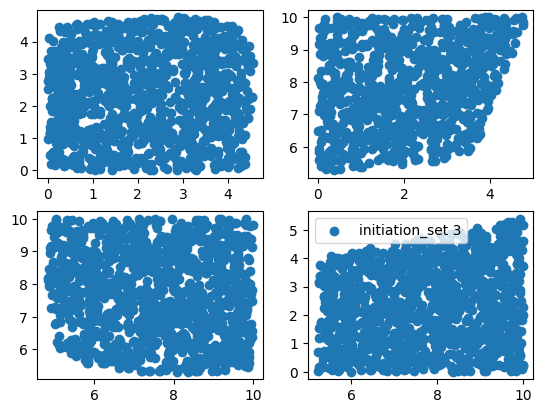

In [13]:
with torch.no_grad():
    x = data[0][0][..., :obs_dim]
    a = data[0][0][...,obs_dim:]
    z = encoder(x)
    logits = initiation_classifier(z[:, :latent_dim])
    z_a = torch.cat((z[:, 0:-1], a), dim=-1)
    z_prime = transition_model(linear_1(z_a) * linear_2(z_a))[..., :latent_dim]
    logits_z_prime = initiation_classifier(z_prime)
    init_masks = logits
    
    for i in range(n_actions):
        plt.subplot(2, 2, i+1)
        plt.scatter(s[init_masks[...,i] > 0.8, 0], s[init_masks[...,i] > 0.8, 1], label=f"initiation_set {i}")
        # plt.scatter(s[data[i][2][...,i] == 1, 0], s[data[i][2][...,i] == 1, 1], label=f"initiation_set (truth) {i}")
        # plt.scatter(s_prime[0][I_s_prime[i,..., i] == 1, 0], s_prime[0][I_s_prime[i,...,i] == 1, 1])
        # plt.scatter(s_prime[0][logits_z_prime[..., i] > 0.7, 0], s_prime[0][logits_z_prime[...,i] > 0.7, 1])

    plt.legend()
    plt.show()

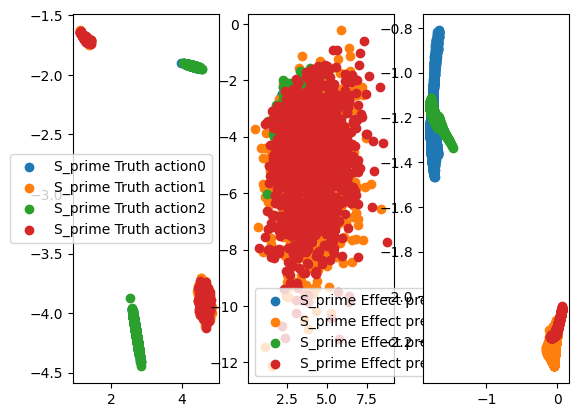

In [14]:
with torch.no_grad():
    for i in range(4):
        
        x = data[i][0][..., :obs_dim]
        i_s = data[i][2][...,i]
        a = data[i][0][i_s ==1, ...,obs_dim:]
        z = encoder(x[i_s==1])
        epsilon = torch.normal(0, 1, (z.size(0), latent_dim))
        z_a = torch.cat((z[:, :latent_dim], a), dim=-1)
        z_prime_prediction = transition_model(linear_1(z_a) * linear_2(z_a))
        # z_prime_prediction = epsilon * z_prime_prediction[..., latent_dim:] + z_prime_prediction[..., :latent_dim]
        s_prime = grounding_model(z_prime_prediction[..., :latent_dim])

        epsilon = torch.normal(0, 1, (s_prime.size(0), obs_dim))
        s_prime_sample = torch.exp(s_prime[..., obs_dim:]) * epsilon + s_prime[..., :obs_dim]
        # s_prime_sample = s_prime[..., :obs_dim]
        z_prime_effect = encoder(s_prime_sample)

        z_prime_truth = encoder(data[i][1][i_s==1,..., :obs_dim])


        logits = initiation_classifier(z[:, :latent_dim])
        plt.subplot(1, 3, 1)
        plt.scatter(z_prime_truth[..., 0], z_prime_truth[..., 1], label=f"S_prime Truth action{i}")
        plt.legend()
        plt.subplot(1, 3, 2)
        plt.scatter(z_prime_effect[..., 0], z_prime_effect[..., 1], label=f"S_prime Effect prediction action{i}")
        plt.legend()
        plt.subplot(1, 3, 3)
        plt.scatter(z_prime_prediction[..., 0], z_prime_prediction[..., 1])
        # plt.legend()
        
    
    plt.show()